In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import scipy.io as sio
from dataclasses import dataclass
from typing import List, Tuple
import os
from dotenv import load_dotenv
load_dotenv()
import tidy3d as td
from tidy3d import web
import numpy as np
from pathlib import Path
from stl import mesh
import matplotlib.pyplot as plt
import re

In [2]:
import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(fr'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [3]:
tidy3dAPI = os.environ["API_TIDY3D_KEY"]


In [4]:
lambdas = np.array([9.5,3.5])

In [5]:
folder_path = rf"../Structures"
project_name = "20251001_LSU_Mean_Free_Path_lt"
postprocess_results = []
runtime_ps = 25e-12
min_steps_per_lambda = 15
cuts=[2]
h5_bg = None
ref = True
for direction in ["z"]: 
    for dirpath, dirnames, filenames in os.walk(folder_path):
        try:
            for filename in filenames:
                if filename.endswith(".h5") and filename=="n_3.30_ff_0.2237.h5":
                    ff = float(re.search(r'ff_([+-]?\d+(?:\.\d+)?)', filename).group(1))
                    n_value = float(re.search(r'n_([+-]?\d+(?:\.\d+)?)', filename).group(1))
                    for cut in cuts:
                        if not (Path(filename).suffix==".h5" or Path(filename).suffix==".stl"):
                            continue 
                        if os.path.isfile(os.path.join(dirpath, filename)):
                            file=os.path.join(dirpath, filename)
                            structure_1 = AM.loadAndRunStructure(key = tidy3dAPI, file_path=file
                                                            ,direction=direction, lambda_range=lambdas,
                                                            box_size=14.3,runtime_ps=runtime_ps,min_steps_per_lambda=min_steps_per_lambda,
                                                           scaling=1,shuoff_condtion=1e-20, verbose=True, 
                                                           monitors=["flux"], flux_monitor_position=18,cell_size_manual=45,
                                                           freqs=180, 
                                                           cut_condition=cut, source="planewave", absorbers=130, use_permittivity=False,sim_name=rf"{Path(filename).stem}_size_{cut}" + (rf"_bg_{h5_bg}" if h5_bg else ""),h5_bg=h5_bg,
                                                           )

        except Exception as e:
            print(f"Error processing {dirpath}: {e}")
        
    



Configured successfully.


<Figure size 1280x960 with 0 Axes>

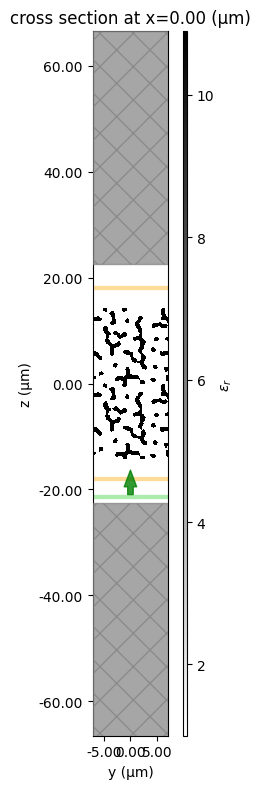

<Figure size 1600x1200 with 0 Axes>

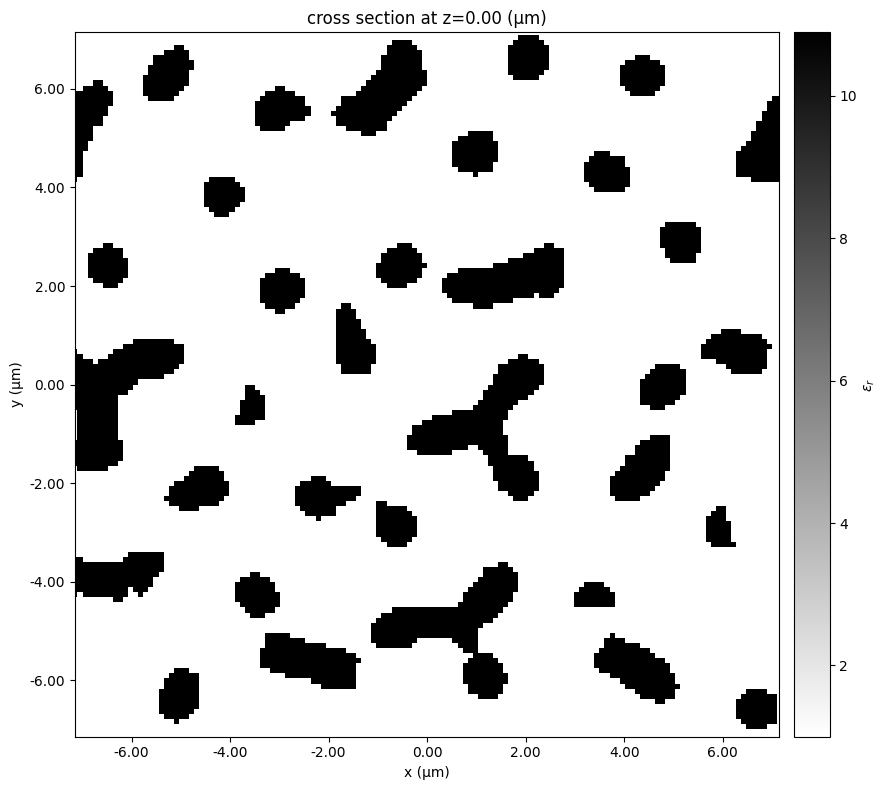

<Figure size 640x480 with 0 Axes>

In [6]:
structure_1.plot_sim_layout()

In [7]:
sim=structure_1.sim

In [8]:
monitor_field = td.FieldMonitor(
                    center=[0.0, 0.0, 0.0],
                    size=[
                            structure_1.t_slab_x if structure_1.direction == "x" else td.inf,
                             structure_1.t_slab_y if structure_1.direction == "y" else td.inf,
                            structure_1.t_slab_z if structure_1.direction == "z" else td.inf
                        ],
                    fields=["Ex","Ey","Ez"],
                    name="field_monitor",
                    freqs =structure_1.monitor_freqs,
                )

In [9]:
sim=sim.copy(update={"monitors":list(sim.monitors) + [monitor_field]})

In [10]:
sim.plot_3d()

In [12]:
sim0=structure_1.sim
sim0=sim.copy(update={"structures":[]})
folder_desc = rf"H:\phd stuff\tidy3d\data\{project_name}\n_{n_value:.2f}"
os.makedirs(folder_desc, exist_ok=True)
sim_name=rf"LSU_{Path(filename).stem}_size_{cut}"
if os.path.exists(os.path.join(folder_desc, sim_name+".txt")):
#     print("Exist!")
# else:
    id =web.upload(sim0, folder_name=project_name,task_name=sim_name, verbose=True)
    # ids = '\n' + id
    # with open(os.path.join(folder_desc, sim_name+".txt"), "w") as file:
    #     # Write the string to the file
    #     file.write(ids)
    web.start(task_id = id)
    web.monitor(id)

16:04:41 W. Europe Daylight Time Created task 'LSU_n_3.30_ff_0.3107_size_2' with
                                 task_id                                        
                                 'fdve-749c15f6-344b-41a9-9885-df00c6534055' and
                                 task_type 'FDTD'.

                                 View task using web UI at                      
                                 ]8;id=181338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=14951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\task]8;;\
                                 ]8;id=14951;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\Id]8;;\]8;id=181338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\=]8;;\]8;id=63343;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\fdve]8;;\]8;id=181338;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\-749c15f6-344b-41a9-9885-df00c6534055']8;;\.

                                 Task folder: ]8;id=867177;https://tidy3d.simulation.cloud/folders/folder-cbaec2de-1988-4cc9-a409-8f1b1e704415\'20251001_LSU_Mean_Free_Path_lt']8;;\.

Output()

16:04:44 W. Europe Daylight Time Maximum FlexCredit cost: 0.114. Minimum cost   
                                 depends on task execution details. Use         
                                 'web.real_cost(task_id)' to get the billed     
                                 FlexCredit cost after a simulation run.

16:04:46 W. Europe Daylight Time status = queued

                                 To cancel the simulation, use                  
                                 'web.abort(task_id)' or 'web.delete(task_id)'  
                                 or abort/delete the task in the web UI.        
                                 Terminating the Python script will not stop the
                                 job running on the cloud.

Output()

16:05:00 W. Europe Daylight Time You are running this simulation for FREE. Your 
                                 current plan allows up to 20 free              
                                 non-concurrent simulations per day (under      
                                 100.0M grid points and 50.0K time steps)

                                 starting up solver

                                 running solver

Output()

16:05:19 W. Europe Daylight Time status = postprocess

Output()

16:05:24 W. Europe Daylight Time status = success

16:05:26 W. Europe Daylight Time View simulation result at                      
                                 ]8;id=85509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=863031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\task]8;;\
                                 ]8;id=863031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\Id]8;;\]8;id=85509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\=]8;;\]8;id=42308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\fdve]8;;\]8;id=85509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-749c15f6-344b-41a9-9885-df00c6534055\-749c15f6-344b-41a9-9885-df00c6534055']8;;\.